# Outline 

## Knowledge Cover

* Grinold (very basics)

## Main Purpose

* Demonstrate superiority in IR of the Ledoit estimator or sample covariance.

## Data Prep

* Daily returns from [historical components](https://github.com/fja05680/sp500) tickers plugged into `yfinance`.
* The problem is, no access to historical market cap/shares outstanding data. 
* But we need these to construct benchmark from weighted average!
* Hacky solution: get all tickers that remained in S&P from start date to today. Use current S&P market cap weights, match to our subset. Normalize to sum to 1, and we have a custom S&P benchmark of selected stocks to use.

## Algo

1. At start of each month `t-1`, select N largest stocks in that universe.
2. Construct the hypothetical market index value (benchmark) and benchmark returns at `t`.
3. Construct the covariance matrix (sample vs Ledoit-Wolf shrinkage) - trailing 5Y `t=60`
4. Construct forecasted excess return vector via the forecast.
5. Feed in benchmark weights, forecasted returns, covariance matrix, desired gain, bound, into optimizer.
6. Produce weight vector. Compute the realized excess return, for each month. Compute IR.
7. Repeat with 50 randomized forecasts
9. Plot out summary statistics and boxplots of IR distribution. See if the Ledoit estimator beats sample covariance.

## Covariance Matrix

* Trailing 5Y, LW vs sample

## Forecasted Return

* Use ex post excess return at `t-1`, add noise (random)
* Z-score this value
* Plug into the Grinold formula for alpha, calculated IC and vol (`t=60`) of realized excess return
* Use the alpha as input into the optimizer.





In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.covariance import LedoitWolf
import cvxpy as cp
from matplotlib import pyplot as plt
from numpy import linalg as LA
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Scrape 2023 S&P Weights 

In [2]:
# load in our stock data
stocks = pd.read_csv('data/d_stocks_2005.csv', index_col='Date', parse_dates=True)

# load in weights
weights = pd.read_csv('data/sp_weights_2023.csv', index_col='ticker')

# keep tickers that were present from start date to 2023 in S&P
weights = weights[weights.index.isin(stocks.columns)]

# renormalize to sum to 1
weights = weights.div(weights.sum())

# store filtered weights for our custom benchmark
weights.to_csv('data/sp_weights_2023_filtered.csv')

## Create Custom S&P Index 

In [3]:
# to get custom returns of benchmark, Ax = b where A is our returns df, x is our weights
d_custom_sp = stocks.dot(weights)
d_custom_sp.to_csv("data/m_sp_custom_2005.csv")

m_custom_sp = d_custom_sp.resample('M').sum()
m_custom_sp.to_csv("data/m_sp_custom_2005.csv")



In [4]:
m_stocks = pd.read_csv('data/m_stocks_2005.csv', index_col='Date', parse_dates=True)
benchmark = pd.read_csv('data/m_sp_custom_2005.csv', index_col='Date', parse_dates=True)


# Portfolio Optimization 

In [5]:
def choose_top_n(stocks, weights, n):
  """
  Simulate the large N stocks in Ledoit's paper
  Returns chosen stocks and custom index values based off N stocks
  """
  weights = weights.sort_values('weights',ascending=0)
  weights = weights.iloc[:n,:]
  weights = weights.div(weights.sum())
  stocks = stocks.loc[:,stocks.columns[stocks.columns.isin(weights.index)]]
  return stocks, stocks.dot(weights), weights


def generate_alphas(excess, ir, breadth, vol):
      # z-score and add noise to get raw scores
      excess = excess.sub(excess.mean()).div(excess.std())
      raw = excess + np.random.standard_normal()
      # calculate information coeff
      ic = ir / np.sqrt(breadth)
      # convert scale raw scores by IC and historical vol to get alphas
      alphas = ic * raw * vol
      return alphas


def calculate_active_performance(stocks, benchmark, weights, cutoff=False, shrinkage=True, reduce=True):
  """
  performs singular run using one random alpha vector of portfolio optimization
  """
  T, n, breadth, ir = 60, stocks.shape[1], stocks.shape[1] * 12, 1.5
  active_holdings, active_returns, alpha_list = [], [], []
  df = stocks.iloc[T:]


  for idx, (date, rets) in enumerate(df.iterrows()):
      
      window = stocks.iloc[idx:idx+T,:]
      vol = window.std() * np.sqrt(12)

      """alpha"""
      benchmark_rets = benchmark.iloc[idx+T]
      excess = rets - benchmark_rets.values
      alphas = generate_alphas(excess, ir, breadth, vol)
      
      """covariance matrix"""
      if shrinkage:
        lw = LedoitWolf()
        lw.fit(window)
        cov = lw.covariance_
      else:
        cov = np.cov(window.T)

      """quadratic optimizer"""
      g = (1+300/1e4)**(1/12) - 1 # monthly gain from 300bps annualized gain
      c = 0.10 # max total holdings
      a, w_b = np.array(alphas).flatten(), np.array(weights).flatten()

      x = cp.Variable(n)
      constraints = [
                      a.T @ x >= g,  # Portfolio's expected return should be at least g
                      cp.sum(x) == 0,  # Active weights are dollar neutral
                      x + w_b >= 0,  # Total positions are long only
                      x <= c * np.ones(n) - w_b  # Upper bound on the total weight
                    ]   
      objective = cp.Minimize(cp.quad_form(x, cov))
      problem = cp.Problem(objective, constraints)
      problem.solve()
      x_optimal = x.value
      """..."""
      
      if not reduce:
        active_holdings.append(x_optimal)
        alpha_list.append(a)
        continue
      else:
        returns = x_optimal @ stocks.iloc[idx+1,:]
        active_returns.append(returns)

  print(date)

  if not reduce:
    active_weights = pd.DataFrame(active_holdings, columns=weights.index, index=df.index)
    alpha_df = pd.DataFrame(alpha_list, columns=weights.index, index=df.index)
    return active_weights, alpha_df
  else:
    active_returns = np.array(active_returns)
    ex_post_ir = active_returns.mean()/active_returns.std()
    return ex_post_ir
    

# Ex-Post Information Ratio Statistics

In [6]:
def generate_ir_stats(runs, n_arr, stocks, weights, shrinkage):
    all_irs = []
    stats = pd.DataFrame()
    for i, n in enumerate(n_arr):
        _stocks, _benchmark, _weights = choose_top_n(stocks, weights, n)
        n_irs = []
        for _ in range(runs):
            ir = calculate_active_performance(_stocks, _benchmark,  _weights,shrinkage=shrinkage, reduce=True)
            n_irs.append(ir)
        all_irs.append(n_irs)
        stats[f'{n}'] = np.array(all_irs[i])

    if shrinkage:
        stats.to_csv("ir_lw.csv")
    else:
        stats.to_csv("ir_sample.csv")
    return stats
        

In [7]:
runs = 50
n_arr = [50, 100, 225, 400]

# stats = generate_ir_stats(runs, n_arr, m_stocks, weights, shrinkage=True)


In [8]:
ir_lw = pd.read_csv("ir_lw.csv").iloc[:,1:]
ir_lw.columns = ['50LW', '100LW', '225LW', '400LW']

In [9]:
ir_sample = pd.read_csv("ir_sample.csv").iloc[:,1:]
ir_sample.columns = ['50S', '100S', '225S', '400S']

In [10]:
ir_df = pd.concat([ir_lw, ir_sample],axis=1).reindex(['50S', '50LW', '100S', '100LW', '225S', '225LW','400S','400LW'],axis=1)

In [11]:
ir_df = ir_df * np.sqrt(12)

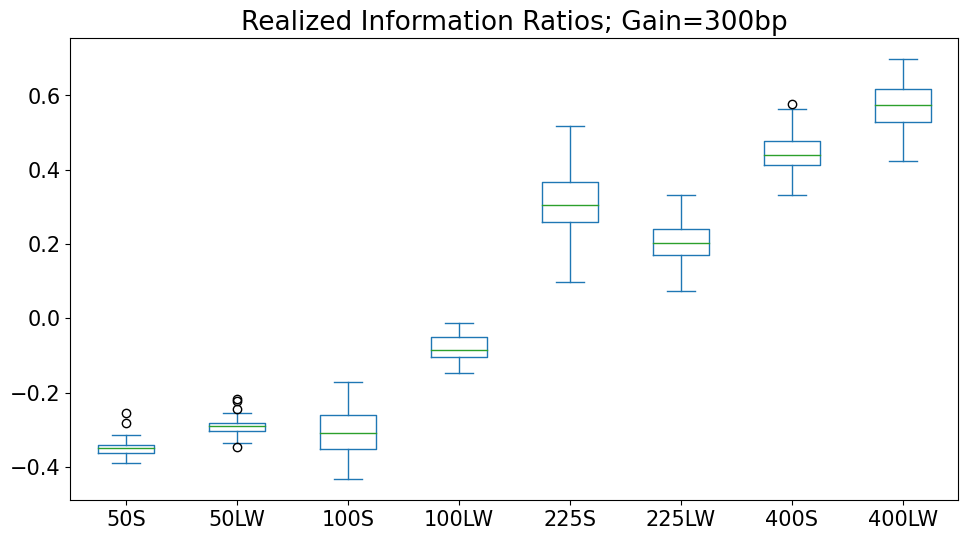

In [115]:
fig, ax = plt.subplots(1,1,figsize=(6*1.91,6))

ir_df.plot(kind='box', ax=ax, showcaps=True, showfliers=True)
ax.set_title( label='Realized Information Ratios; Gain=300bp', fontsize=19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# ax.set_aspect(1.91)
# plt.xlabel('N', fontsize=17)
# plt.ylabel('IR', fontsize=17)
plt.show()

# Covariance Matrix Testing

1. Mathematical properties of the sample cov. vs shrunk cov.
    * Eigenvalues
    * Rank (invertibility)
2. Feel for why these properties are like so.
    * Proof based (no time)
    * Intuition based (calculate cov. as a toy example, with n=10, p=5)
3. How these properties affect weights produced by optimization.
    * Good feel of how quadratic optimization algorithms (like our cvxpy programs work).
    * Enough to connect the dots.


* Mathematical explanation of why sample cov is bad in portfolio optimization
    * https://quant.stackexchange.com/questions/11564/why-shrink-the-covariance-matrix
    * https://quant.stackexchange.com/questions/10101/portfolio-optimization-shrinkage-of-covariance-matrix-when-data-is-available
    * https://public.lanl.gov/jt/Papers/shrink-post-SPIE8391.pdf
    * https://stats.stackexchange.com/questions/472055/rank-of-sample-covariance-matrix-when-p-n
    * Post MUST have this! MUST figure it out and connect all the dots.
* Empirical weakness of sample cov - look at over allocation
    * Boxplot of cross-sectional std of weights for sample cov
    * Overlay allocation lineplot



In [13]:
_stocks, _benchmark, _weights = choose_top_n(m_stocks, weights, 100)
s_weights, s_alphas = calculate_active_performance(_stocks, _benchmark, _weights, shrinkage=False, cutoff=False, reduce=False)
lw_weights, lw_alphas = calculate_active_performance(_stocks, _benchmark, _weights, shrinkage=True, cutoff=False, reduce=False)

2022-12-31 00:00:00
2022-12-31 00:00:00


In [85]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming weights_df and alphas_df have the same dimensions (rows and columns)
# If not, you may need to align them accordingly

def calc_similarity(weights, alphas, name):

    cosine_sim_matrix = cosine_similarity(weights, alphas).diagonal()
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=s_weights.index,columns=[name])
    return cosine_sim_df

colors = {'Sample': 'tab:blue', 'Ledoit-Wolf': 'tab:pink'}


In [15]:
s_cosine = calc_similarity(s_weights, s_alphas, 'Sample')
lw_cosine = calc_similarity(lw_weights, lw_alphas, 'Ledoit-Wolf')

cosines_sim = pd.concat([s_cosine,lw_cosine],axis=1)

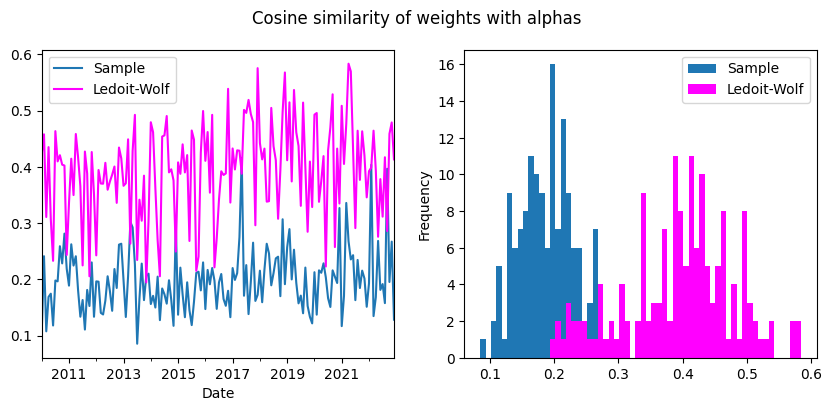

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

cosines_sim.plot( color=colors, ax=ax[0])
cosines_sim.plot(ax=ax[1], kind='hist', bins=60, color=colors)
fig.suptitle('Cosine similarity of weights with alphas', fontsize=12)
plt.show()

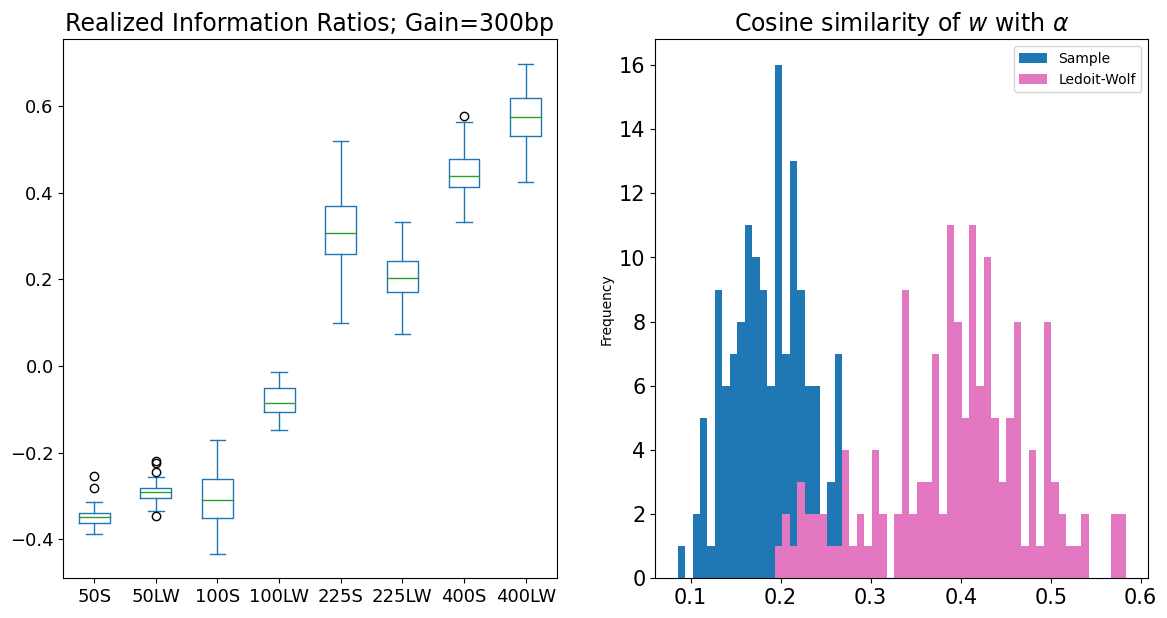

In [93]:

fig, ax = plt.subplots(1,2, figsize=(14,7))

ir_df.plot(kind='box', ax=ax[0],  showcaps=True, showfliers=True, fontsize=13)
cosines_sim.plot(ax=ax[1], kind='hist', bins=60, color=colors, fontsize=15)
ax[0].set_title(label='Realized Information Ratios; Gain=300bp',fontsize=17)
ax[1].set_title(label=r'Cosine similarity of $w$ with $\alpha$',fontsize=17)
# ax[0].set_xlabel('N')
plt.show()

In [18]:
lw_turnover = lw_weights.diff().abs().sum(axis=1)
s_turnover = s_weights.diff().abs().sum(axis=1)

In [19]:
turnover = pd.DataFrame()
turnover['Sample'] = s_turnover
turnover['Ledoit-Wolf'] = lw_turnover


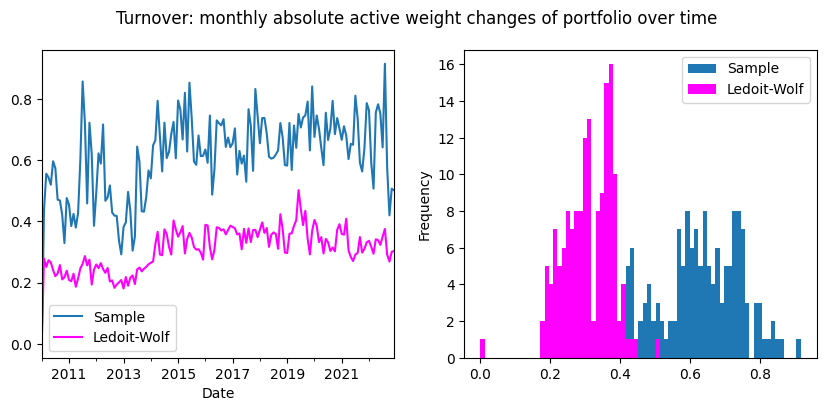

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

turnover.plot(color=colors, ax=ax[0])
turnover.plot(kind='hist', bins=75, color=colors, ax=ax[1])
fig.suptitle('Turnover: monthly absolute active weight changes of portfolio over time', fontsize=12)
plt.show()


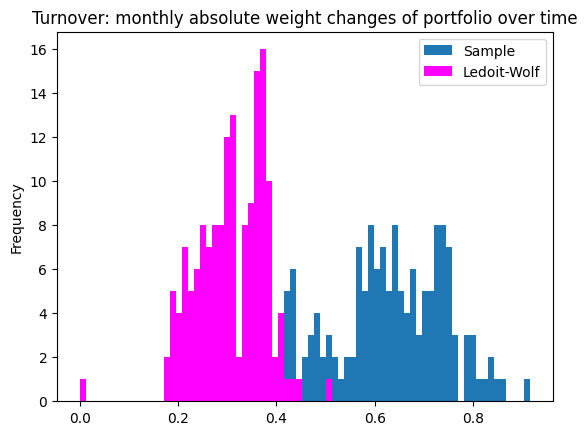

In [21]:

turnover.plot(title='Turnover: monthly absolute weight changes of portfolio over time', kind='hist', bins=75, color=colors)

plt.show()